In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import os
from datetime import datetime
import darts as dt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
(Stepwise ,
sklearn_selected ,
sklearn_selection_path)
from l0bnb import fit_path

In [2]:
ticker = yf.Ticker(ticker='AAPL').history('1y')

$AAPL: possibly delisted; no price data found  (period=1y)


In [3]:
filepath = "/Users/mudit.000/OneDrive - University of Essex/Documents/GitHub/Personal-Research-Learning/Personal-Research-Learning/NSE-Stock-Historical-Data/v1"

In [4]:
dp = pl.read_csv(filepath + "/3IINFOLTD.NS.csv")

In [5]:
stocklist = []
stocknames = []

In [6]:
for files in os.listdir(filepath):
    stocknames.append(files)
    stocklist.append(pl.read_csv(filepath + "/" + files))

In [7]:
stocknames = pl.Series(stocknames)

In [8]:
stocknames = stocknames.str.replace(".NS.csv", "")

In [9]:
stocknames

shape: (1_940,)
Series: '' [str]
[
	"20MICRONS"
	"21STCENMGM"
	"360ONE"
	"3IINFOLTD"
	"3MINDIA"
	…
	"ZOTA"
	"ZUARI"
	"ZUARIIND"
	"ZYDUSLIFE"
	"ZYDUSWELL"
]

In [10]:
stocklist

[shape: (3_714, 8)
 ┌─────────────┬─────────────┬────────────┬────────────┬────────────┬──────────┬───────────┬────────┐
 │ Date        ┆ Open        ┆ High       ┆ Low        ┆ Close      ┆ Volume   ┆ Dividends ┆ Stock  │
 │ ---         ┆ ---         ┆ ---        ┆ ---        ┆ ---        ┆ ---      ┆ ---       ┆ Splits │
 │ str         ┆ f64         ┆ f64        ┆ f64        ┆ f64        ┆ i64      ┆ f64       ┆ ---    │
 │             ┆             ┆            ┆            ┆            ┆          ┆           ┆ f64    │
 ╞═════════════╪═════════════╪════════════╪════════════╪════════════╪══════════╪═══════════╪════════╡
 │ 2008-10-06  ┆ 35.138197   ┆ 35.138197  ┆ 13.879588  ┆ 14.736081  ┆ 23501600 ┆ 0.0       ┆ 0.0    │
 │ 00:00:00+05 ┆             ┆            ┆            ┆            ┆          ┆           ┆        │
 │ :30         ┆             ┆            ┆            ┆            ┆          ┆           ┆        │
 │ 2008-10-07  ┆ 14.055279   ┆ 16.690643  ┆ 12.232485  ┆ 13.198

In [11]:
temp = []
for x in stocklist:
    temp.append(x.with_columns(pl.col('Date').str.slice(0,10).alias('Date')))

stocklist = temp

In [12]:
temp = pl.DataFrame()
i = 0
for x in stocklist:
    try:
        temp = temp.vstack(x)
        i += 1
    except:
        print(i)
        break

25


In [13]:
temp = []
for x in stocklist:
    temp.append(pl.Series(np.log(x["Close"] ) - np.log(x["Open"])))
logstock = temp

c:\Users\mudit.000\OneDrive - University of Essex\Documents\GitHub\Personal-Research-Learning\Personal-Research-Learning\.venv\Lib\site-packages\polars\series\series.py:1458: RuntimeWarning: invalid value encountered in log
  lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs),
c:\Users\mudit.000\OneDrive - University of Essex\Documents\GitHub\Personal-Research-Learning\Personal-Research-Learning\.venv\Lib\site-packages\polars\series\series.py:1458: RuntimeWarning: divide by zero encountered in log
  lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs),


In [14]:
stocklist[1]

shape: (1_434, 8)
┌────────────┬───────────┬───────────┬───────────┬───────────┬────────┬───────────┬──────────────┐
│ Date       ┆ Open      ┆ High      ┆ Low       ┆ Close     ┆ Volume ┆ Dividends ┆ Stock Splits │
│ ---        ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---    ┆ ---       ┆ ---          │
│ str        ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ i64    ┆ f64       ┆ f64          │
╞════════════╪═══════════╪═══════════╪═══════════╪═══════════╪════════╪═══════════╪══════════════╡
│ 2018-01-11 ┆ 31.14629  ┆ 31.14629  ┆ 31.14629  ┆ 31.14629  ┆ 157    ┆ 0.0       ┆ 0.0          │
│ 2018-01-12 ┆ 31.752428 ┆ 31.752428 ┆ 31.752428 ┆ 31.752428 ┆ 360    ┆ 0.0       ┆ 0.0          │
│ 2018-01-15 ┆ 32.35857  ┆ 32.35857  ┆ 32.35857  ┆ 32.35857  ┆ 795    ┆ 0.0       ┆ 0.0          │
│ 2018-01-16 ┆ 32.964706 ┆ 32.964706 ┆ 32.964706 ┆ 32.964706 ┆ 2735   ┆ 0.0       ┆ 0.0          │
│ 2018-01-17 ┆ 33.617474 ┆ 33.617474 ┆ 33.011335 ┆ 33.617474 ┆ 56033  ┆ 0.0       ┆ 0.0          │
│ …          ┆ …         ┆ …         ┆ …         ┆ …         ┆ …      ┆ …         ┆ …            │
│ 2023-10-26 ┆ 18.299999 ┆ 18.75     ┆ 18.200001 ┆ 18.5      ┆ 6333   ┆ 0.0       ┆ 0.0          │
│ 2023-10-27 ┆ 18.5      ┆ 18.5      ┆ 18.15     ┆ 18.299999 ┆ 1101   ┆ 0.0       ┆ 0.0          │
│ 2023-10-30 ┆ 18.200001 ┆ 18.5      ┆ 18.15     ┆ 18.25     ┆ 2663   ┆ 0.0       ┆ 0.0          │
│ 2023-10-31 ┆ 18.5      ┆ 18.5      ┆ 17.9      ┆ 18.1      ┆ 6366   ┆ 0.0       ┆ 0.0          │
│ 2023-11-01 ┆ 17.950001 ┆ 18.299999 ┆ 17.799999 ┆ 17.799999 ┆ 3806   ┆ 0.0       ┆ 0.0          │
└────────────┴───────────┴───────────┴───────────┴───────────┴────────┴───────────┴──────────────┘

In [15]:
temp = []
for i in zip(range(len(stocklist)),stocknames):
    temp2 = stocklist[i[0]].hstack([logstock[i[0]].alias(i[1])])
    temp.append(temp2)
stocklist = temp

In [16]:
stocklist[1]

shape: (1_434, 9)
┌──────────────┬───────────┬───────────┬───────────┬───┬────────┬───────────┬────────┬─────────────┐
│ Date         ┆ Open      ┆ High      ┆ Low       ┆ … ┆ Volume ┆ Dividends ┆ Stock  ┆ 21STCENMGM  │
│ ---          ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---    ┆ ---       ┆ Splits ┆ ---         │
│ str          ┆ f64       ┆ f64       ┆ f64       ┆   ┆ i64    ┆ f64       ┆ ---    ┆ f64         │
│              ┆           ┆           ┆           ┆   ┆        ┆           ┆ f64    ┆             │
╞══════════════╪═══════════╪═══════════╪═══════════╪═══╪════════╪═══════════╪════════╪═════════════╡
│ 2018-01-11   ┆ 31.14629  ┆ 31.14629  ┆ 31.14629  ┆ … ┆ 157    ┆ 0.0       ┆ 0.0    ┆ 0.0         │
│ 2018-01-12   ┆ 31.752428 ┆ 31.752428 ┆ 31.752428 ┆ … ┆ 360    ┆ 0.0       ┆ 0.0    ┆ 0.0         │
│ 2018-01-15   ┆ 32.35857  ┆ 32.35857  ┆ 32.35857  ┆ … ┆ 795    ┆ 0.0       ┆ 0.0    ┆ 0.0         │
│ 2018-01-16   ┆ 32.964706 ┆ 32.964706 ┆ 32.964706 ┆ … ┆ 2735   ┆ 0.0       ┆ 0.0    ┆ 0.0         │
│ 2018-01-17   ┆ 33.617474 ┆ 33.617474 ┆ 33.011335 ┆ … ┆ 56033  ┆ 0.0       ┆ 0.0    ┆ 0.0         │
│ …            ┆ …         ┆ …         ┆ …         ┆ … ┆ …      ┆ …         ┆ …      ┆ …           │
│ 2023-10-26   ┆ 18.299999 ┆ 18.75     ┆ 18.200001 ┆ … ┆ 6333   ┆ 0.0       ┆ 0.0    ┆ 0.01087     │
│ 2023-10-27   ┆ 18.5      ┆ 18.5      ┆ 18.15     ┆ … ┆ 1101   ┆ 0.0       ┆ 0.0    ┆ -0.01087    │
│ 2023-10-30   ┆ 18.200001 ┆ 18.5      ┆ 18.15     ┆ … ┆ 2663   ┆ 0.0       ┆ 0.0    ┆ 0.002743    │
│ 2023-10-31   ┆ 18.5      ┆ 18.5      ┆ 17.9      ┆ … ┆ 6366   ┆ 0.0       ┆ 0.0    ┆ -0.021859   │
│ 2023-11-01   ┆ 17.950001 ┆ 18.299999 ┆ 17.799999 ┆ … ┆ 3806   ┆ 0.0       ┆ 0.0    ┆ -0.008392   │
└──────────────┴───────────┴───────────┴───────────┴───┴────────┴───────────┴────────┴─────────────┘

In [17]:
temp = []
for i in range(len(stocklist)):
    temp.append(stocklist[i].with_columns(pl.col("Date").str.strptime(dtype = pl.Date, format = "%Y-%m-%d").alias("Date")))
stocklist = temp

In [18]:
temp = []
for i in range(len(stocklist)):
    temp2 = stocklist[i].filter(pl.col("Date") > pl.date(2022,1,1))
    temp2 = temp2.filter(pl.col("Date") < pl.date(2022,12,31))
    temp2 = temp2.sort(pl.col("Date"))
    temp.append(temp2)
projlist = temp

In [19]:
temp = []
for x in projlist:
    temp.append(x.drop(["Open", "High", "Low", "Close","Volume", "Dividends", "Stock Splits"]))
maslist = temp

In [20]:
pl.DataFrame({stocknames[0]:np.log(projlist[0]['Close'])-np.log(projlist[0]['Open'])})

shape: (248, 1)
┌───────────┐
│ 20MICRONS │
│ ---       │
│ f64       │
╞═══════════╡
│ -0.029356 │
│ -0.034835 │
│ -0.009065 │
│ 0.031074  │
│ 0.170844  │
│ …         │
│ 0.045342  │
│ 0.003974  │
│ 0.008406  │
│ 0.031784  │
│ -0.004384 │
└───────────┘

In [21]:
dictdf = {stocknames[i]:np.log(projlist[i]['Close'])-np.log(projlist[i]['Open']) for i in range(0,len(stocknames))}

In [22]:
listkeys=list()
lenkeys=list()
for key in dictdf:
    lenkeys.append(len(dictdf[key]))
    if len(dictdf[key]) != 248:
        listkeys.append(key)


In [23]:
pd.DataFrame(lenkeys).value_counts()

0  
248    1803
0        17
246       9
250       9
180       4
       ... 
81        1
80        1
79        1
74        1
133       1
Name: count, Length: 86, dtype: int64

In [24]:
for i in listkeys:
    if len(dictdf[i]) != 248:
        #dictdf.pop(i,None)
        del dictdf[i]

In [25]:
pldf = pl.DataFrame(dictdf)

In [26]:
pldf

shape: (248, 1_803)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ 20MICRONS ┆ 21STCENMG ┆ 360ONE    ┆ 3IINFOLTD ┆ … ┆ ZUARI     ┆ ZUARIIND  ┆ ZYDUSLIFE ┆ ZYDUSWEL │
│ ---       ┆ M         ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ L        │
│ f64       ┆ ---       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ ---      │
│           ┆ f64       ┆           ┆           ┆   ┆           ┆           ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ -0.029356 ┆ -0.002139 ┆ 0.027456  ┆ -0.012237 ┆ … ┆ -0.015013 ┆ -0.016406 ┆ -0.016727 ┆ -0.00391 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 5        │
│ -0.034835 ┆ -0.00421  ┆ 0.010456  ┆ 0.006501  ┆ … ┆ 0.010406  ┆ 0.070586  ┆ -0.029999 ┆ -0.00553 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
│ -0.009065 ┆ -0.032721 ┆ 0.023895  ┆ -0.01688  ┆ … ┆ 0.028585  ┆ -0.040889 ┆ -0.014392 ┆ 0.012126 │
│ 0.031074  ┆ -0.016    ┆ -0.00929  ┆ 0.009495  ┆ … ┆ 0.00444   ┆ 0.059308  ┆ -0.001967 ┆ -0.01159 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 2        │
│ 0.170844  ┆ 0.026811  ┆ 0.012645  ┆ 0.017612  ┆ … ┆ -0.023407 ┆ -0.032717 ┆ -0.019563 ┆ -0.01150 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ 0.045342  ┆ -0.006689 ┆ 0.015773  ┆ 0.029061  ┆ … ┆ 0.062304  ┆ 0.070697  ┆ -0.000594 ┆ 0.01773  │
│ 0.003974  ┆ 0.0       ┆ 0.000369  ┆ -0.003711 ┆ … ┆ 0.026474  ┆ 0.008251  ┆ -0.008786 ┆ -0.00579 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
│ 0.008406  ┆ -0.017739 ┆ -0.001624 ┆ -0.002463 ┆ … ┆ 0.042641  ┆ 0.028181  ┆ -0.012683 ┆ -0.00254 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 7        │
│ 0.031784  ┆ -0.024527 ┆ 0.001765  ┆ -0.003706 ┆ … ┆ 0.030904  ┆ 0.025405  ┆ 0.005044  ┆ -0.01082 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 4        │
│ -0.004384 ┆ 0.024693  ┆ 0.011123  ┆ -0.006116 ┆ … ┆ -0.017239 ┆ -0.001345 ┆ 0.001191  ┆ 0.000531 │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [94]:
#Hitters = pldf.to_pandas()
Hitters = pd.read_csv("asx99.csv")
np.isnan(Hitters).sum()

Date    0
ABC     0
AGL     0
AIO     0
ALL     0
       ..
WBC     0
WES     0
WFD     0
WOW     0
WPL     0
Length: 100, dtype: int64

In [96]:
design = MS(Hitters.columns.drop('ABC')).fit(Hitters)
Y = np.array(Hitters['ABC'])
X = design.transform(Hitters)
sigma2 = OLS(Y,X).fit().scale

In [97]:
def nCp(sigma2 , estimator , X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    
    return -(RSS + 2 * p * sigma2) / n

In [98]:
neg_Cp = partial(nCp , sigma2)

In [99]:
strategy = Stepwise.first_peak(design ,
direction='forward ',
max_terms=len(design.terms))

In [100]:
Hitters

Date       ABC       AGL       AIO       ALL       ALQ       AMC  \
0    20150105  0.005495  0.012542 -0.003295  0.004563  0.000000  0.001472   
1    20150106 -0.013793 -0.013284 -0.011618 -0.009146 -0.045462 -0.003683   
2    20150107  0.000000  0.003708 -0.006700 -0.001533  0.019194 -0.010386   
3    20150108  0.008299  0.004431  0.010034  0.018238 -0.050693 -0.015784   
4    20150109  0.010959  0.011722  0.014864  0.016431  0.033435  0.004535   
..        ...       ...       ...       ...       ...       ...       ...   
248  20151223  0.010977 -0.002301  0.000000  0.004012  0.033523 -0.005293   
249  20151224  0.017316  0.008603 -0.006842  0.004993  0.005479  0.009808   
250  20151229  0.021232  0.023703  0.000000  0.016791  0.032261  0.004494   
251  20151230  0.008368  0.001115  0.006842  0.005859  0.020943  0.011887   
252  20151231 -0.010471  0.007216 -0.006842 -0.005859 -0.023592 -0.007413   

          AMP       ANN       ANZ  ...       TPM       TTS       TWE  \
0    0.001797  0.002656 -0.001863  ... -0.016309 -0.002861 -0.010515   
1   -0.019946 -0.018292 -0.012197  ... -0.036534 -0.008633 -0.002116   
2    0.003656  0.005836 -0.001890  ... -0.004662  0.000000 -0.017094   
3   -0.003656  0.004912  0.005972  ...  0.010844  0.011494 -0.017392   
4    0.019946  0.008428  0.014930  ...  0.022849  0.014185  0.023836   
..        ...       ...       ...  ...       ...       ...       ...   
248  0.003571 -0.010074  0.007468  ...  0.004024  0.000000 -0.008647   
249  0.012401  0.008641  0.013671  ... -0.019261  0.016298  0.014779   
250  0.019181  0.016122  0.013849  ...  0.020264  0.000000 -0.001223   
251  0.012017  0.017716  0.011873  ... -0.003014  0.006905  0.000000   
252 -0.005133 -0.009752 -0.001074  ... -0.005043  0.006857  0.015787   

          VCX       VOC       WBC       WES       WFD       WOW       WPL  
0    0.000000 -0.004713 -0.003312 -0.000955  0.015168 -0.012814  0.005232  
1    0.000000 -0.015873 -0.008784 -0.004068 -0.005391 -0.014657 -0.050017  
2    0.000000 -0.012883 -0.005491 -0.006496  0.022449  0.005021 -0.008815  
3    0.000000  0.009677  0.003664  0.009130  0.018849 -0.010405 -0.004993  
4    0.000000  0.004804  0.017823  0.021532 -0.001038  0.019379  0.029861  
..        ...       ...       ...       ...       ...       ...       ...  
248  0.010582  0.000000  0.001873  0.000745  0.002103  0.005078  0.010567  
249 -0.007042  0.001363  0.014861  0.009137  0.005238  0.024188  0.021159  
250  0.003527  0.012187  0.014643  0.026681  0.009360  0.023617  0.008129  
251 -0.003527  0.012040  0.019197  0.004537  0.004132  0.006818  0.014328  
252 -0.010657  0.000000 -0.002975 -0.008615 -0.019782 -0.021002 -0.003476  

[253 rows x 100 columns]

In [101]:
D = design.fit_transform(Hitters)
X = np.asarray(D)

In [102]:
isnan = np.isnan(Xs)

In [103]:
np.where(isnan == True)

(array([  0,   0,   0, ..., 247, 247, 247], dtype=int64),
 array([   5,   52,   66, ..., 1741, 1772, 1794], dtype=int64))

In [ ]:
Xs = X - X.mean(0)[:]
X_scale = X.std (0)
Xs = Xs / X_scale[None ,:]
lambdas = 10**np.linspace (8, -2, 100) / Y.std()
Xs
soln_array = skl.ElasticNet.path(Xs,
Y,
l1_ratio =1,
alphas=lambdas)[1]
soln_array.shape

C:\Users\mudit.000\AppData\Local\Temp\ipykernel_19288\2764638004.py:3: RuntimeWarning: invalid value encountered in divide
  Xs = Xs / X_scale[None ,:]


ValueError: Input contains NaN.

In [ ]:
print(np.isnan(Xs).sort())

None


In [ ]:
D = design.fit_transform(Hitters)
D = D.drop(['intercept'], axis=1)
X = np.asarray(D)

In [ ]:
scaler = StandardScaler(with_mean=True , with_std=True)

In [ ]:
K = 5
kfold = skm.KFold(K,
random_state=0,
shuffle=True)

In [ ]:
lassoCV = skl.ElasticNetCV(n_alphas =100,
l1_ratio =1,
cv=kfold)
pipeCV = Pipeline(steps =[('scaler ', scaler),
('lasso ', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso ']
tuned_lasso.alpha_

0.003177553196236978

In [ ]:
np.any(np.isnan(Xs))

True

In [ ]:
lambdas , soln_array = skl.Lasso.path(Xs ,
Y,
l1_ratio =1,
n_alphas =100) [:2]
soln_path = pd.DataFrame(soln_array.T,
columns=D.columns ,
index=-np.log(lambdas))

ValueError: Input contains NaN.

In [ ]:
D

21STCENMGM    360ONE  3IINFOLTD   3MINDIA    3PLAND  3RDROCK    5PAISA  \
0     -0.002139  0.027456  -0.012237  0.013629  0.000000      0.0  0.036213   
1     -0.004210  0.010456   0.006501 -0.003451  0.005305      0.0 -0.015628   
2     -0.032721  0.023895  -0.016880 -0.003295  0.000000      0.0  0.049690   
3     -0.016000 -0.009290   0.009495  0.002030  0.000000      0.0  0.017849   
4      0.026811  0.012645   0.017612  0.007636  0.000000      0.0  0.014121   
..          ...       ...        ...       ...       ...      ...       ...   
243   -0.006689  0.015773   0.029061  0.005905  0.090545      0.0  0.015802   
244    0.000000  0.000369  -0.003711 -0.003484 -0.023393      0.0  0.013106   
245   -0.017739 -0.001624  -0.002463 -0.016959  0.000000      0.0 -0.025306   
246   -0.024527  0.001765  -0.003706 -0.007813  0.043803      0.0 -0.003597   
247    0.024693  0.011123  -0.006116 -0.005995 -0.043675      0.0  0.002442   

      63MOONS  A2ZINFRA   AAATECH  ...    ZENTEC  ZFCVINDIA  ZICOM  \
0    0.015778  0.000000  0.000000  ... -0.003219  -0.023995    0.0   
1    0.000000  0.000000  0.000000  ... -0.001820   0.003231    0.0   
2    0.011618  0.004598  0.000000  ... -0.001147   0.014263    0.0   
3    0.000000  0.035718  0.000000  ...  0.008528  -0.029379    0.0   
4    0.000000  0.000000  0.003221  ...  0.048604   0.008020    0.0   
..        ...       ...       ...  ...       ...        ...    ...   
243  0.044098  0.137784  0.037179  ...  0.000000   0.022737    0.0   
244  0.011789 -0.074848  0.006231  ... -0.003693  -0.005895    0.0   
245  0.000000  0.010152  0.008011  ... -0.005556  -0.012882    0.0   
246  0.070895  0.005038  0.010573  ... -0.021121  -0.011563    0.0   
247 -0.002384 -0.019901 -0.031253  ... -0.016151   0.016014    0.0   

     ZODIACLOTH    ZOMATO      ZOTA     ZUARI  ZUARIIND  ZYDUSLIFE  ZYDUSWELL  
0      0.019749  0.011742  0.006924 -0.015013 -0.016406  -0.016727  -0.003915  
1     -0.016987 -0.021452 -0.024751  0.010406  0.070586  -0.029999  -0.005538  
2     -0.004981 -0.029062 -0.017021  0.028585 -0.040889  -0.014392   0.012126  
3      0.028464 -0.022815 -0.002052  0.004440  0.059308  -0.001967  -0.011592  
4      0.005305 -0.005786 -0.026297 -0.023407 -0.032717  -0.019563  -0.011508  
..          ...       ...       ...       ...       ...        ...        ...  
243    0.012869  0.074968  0.059838  0.062304  0.070697  -0.000594   0.017730  
244   -0.010605 -0.007605  0.024693  0.026474  0.008251  -0.008786  -0.005798  
245    0.043657  0.027815  0.045599  0.042641  0.028181  -0.012683  -0.002547  
246    0.012103  0.022435 -0.007012  0.030904  0.025405   0.005044  -0.010824  
247   -0.021990 -0.028265  0.012093 -0.017239 -0.001345   0.001191   0.000531  

[248 rows x 1802 columns]

NameError: name 'soln_path' is not defined

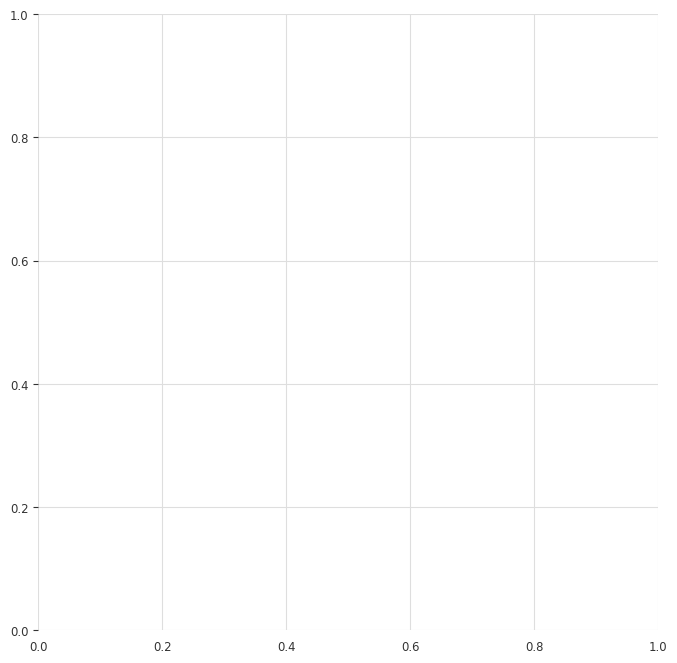

In [ ]:
path_fig , ax = subplots(figsize =(8 ,8))
soln_path.plot(ax=ax , legend=False)
ax.set_xlabel('$-\log(\ lambda)$', fontsize =20)
ax.set_ylabel('Standardized coefficiients ', fontsize =20)

In [ ]:
np.min(tuned_lasso.mse_path_.mean (1))

0.001053045825794297

Text(0, 0.5, 'Cross -validated MSE')

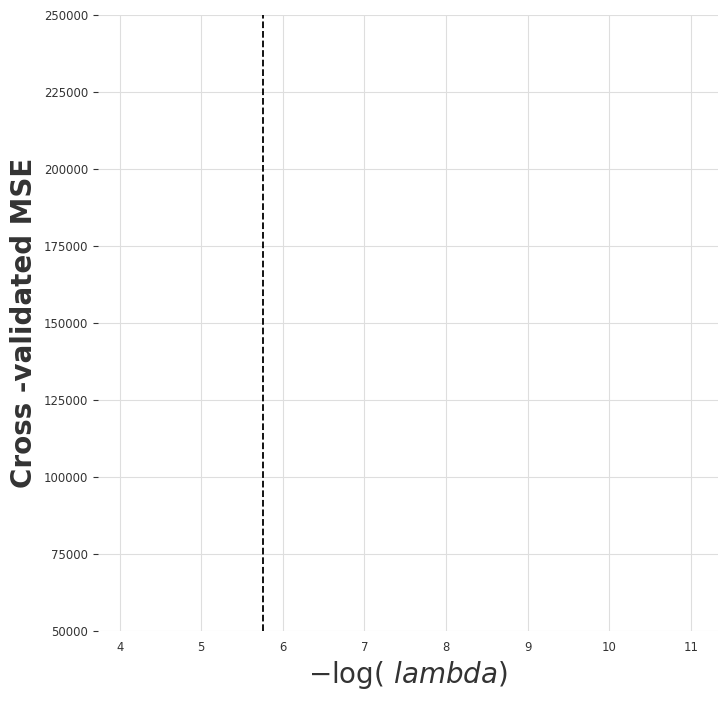

In [ ]:
lassoCV_fig , ax = subplots(figsize =(8 ,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
tuned_lasso.mse_path_.mean (1),
yerr=tuned_lasso.mse_path_.std (1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim ([50000 ,250000])
ax.set_xlabel('$-\log(\ lambda)$', fontsize =20)
ax.set_ylabel('Cross -validated MSE', fontsize =20)

-0.003429033155124535